In [7]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
# !pip install gluonts=="0.4.1"

In [10]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [11]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


In [12]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_qu

#### Note

In SageMaker data are saved into the following folders (example shows m4_weekly):

```
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json
```

In [13]:
dataname = "m4_weekly"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_weekly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json


In [14]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length
print("length train dataset:", len(dataset.train))
print("length test dataset:", len(dataset.test))

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset: 359
length test dataset: 359


In [15]:
train_entry

{'start': Timestamp('1750-01-04 00:00:00', freq='W-SUN'),
 'target': array([ 1089.2 ,  1078.91,  1079.88, ..., 36565.18, 36565.18, 35397.16],
       dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json'), line=1), row=1)}

## Plot Series

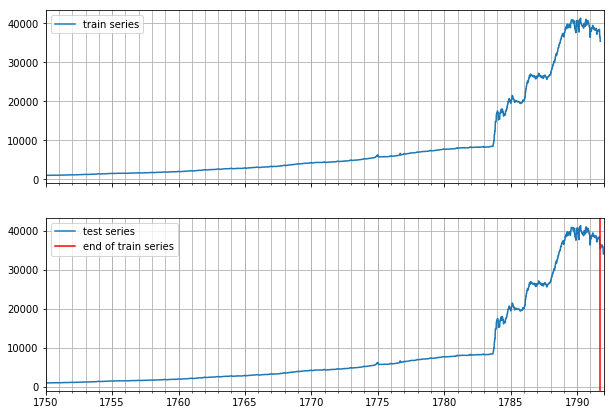

In [16]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [17]:
print("start:", dict(train_entry)["start"])
print("target:", dict(train_entry)["target"][:7])
print("feat_static_cat:", dict(train_entry)["feat_static_cat"])
print("length:", len(dataset.train))

start: 1750-01-04 00:00:00
target: [1089.2  1078.91 1079.88 1063.58 1060.61 1056.93 1056.63]
feat_static_cat: [0]
length: 359


In [18]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator

INFO:root:Using CPU


In [19]:
#########################
### deepstate wrapper ###

# data = "m4_yearly_other"
# seed = 44
# epochs = 500
# num_batches = 100
# batch_size = 32

def deepstate(dataname, seed=42, epochs=100, num_batches=50):
    
    mx.random.seed(seed)
    np.random.seed(seed)

    dataset = get_dataset(dataname, regenerate=False)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
        )

    cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
    estimator = DeepStateEstimator(
        trainer=trainer,
        cardinality=[cardinality],
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True,
        )

    predictor=estimator.train(dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
            dataset.test, predictor=predictor, num_samples=100
        )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = num_batches
    output["data"] = dataname

    df = pd.DataFrame([output])
    return df

## Results

In [ ]:
results = pd.DataFrame()

for i in range(62, 65):
    print("Seed:", i)
    df=deepstate(dataname="m4_yearly", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

## m4_monthly

In [36]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_monthly", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 50/50 [00:09<00:00,  5.16it/s, avg_epoch_loss=0.0975]
INFO:root:Epoch[0] Elapsed time 9.708 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.097503
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.34it/s, avg_epoch_loss=-.184]
INFO:root:Epoch[1] Elapsed time 9.360 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.183824
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.40it/s, avg_epoch_loss=0.317]
INFO:root:Epoch[2] Elapsed time 9.257 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.317048
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.38it/s, avg_epoch_loss=0.146]
INFO:root:Epoch[3] Elapsed time 9.299 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.146055
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.35it/s, avg_epoch_loss

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.404726
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:09<00:00,  5.32it/s, avg_epoch_loss=-.755]
INFO:root:Epoch[37] Elapsed time 9.410 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.755307
INFO:root:Loading parameters from best epoch (7)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.35it/s, avg_epoch_loss=31.1]
INFO:root:Epoch[38] Elapsed time 9.348 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=31.082841
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.41it/s, avg_epoch_loss=28.3]
INFO:root:Epoch[39] Elapsed time 9.254 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=28.282993
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.30it/s, avg_epoch_loss=11.4]
INFO:root:Epoch[40] Elapsed time 9.434 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=11.37223

100%|██████████| 50/50 [00:09<00:00,  5.29it/s, avg_epoch_loss=-.796]
INFO:root:Epoch[73] Elapsed time 9.454 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.795789
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.36it/s, avg_epoch_loss=-1.2]
INFO:root:Epoch[74] Elapsed time 9.335 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.202862
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.43it/s, avg_epoch_loss=-1.09]
INFO:root:Epoch[75] Elapsed time 9.212 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.089581
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.30it/s, avg_epoch_loss=-.883]
INFO:root:Epoch[76] Elapsed time 9.462 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.882560
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.42it/s, avg_epoch_loss=-.979]
INFO:root:Epoch[77] Elapsed time 9.221 seconds


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.041645  0.144527  24.763482            0.128765            0.104546   

   seed  epochs  num_batches        data  
0    42     100           50  m4_monthly  
Seed: 43


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 50/50 [00:10<00:00,  4.99it/s, avg_epoch_loss=-.0425]
INFO:root:Epoch[0] Elapsed time 10.034 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.042517
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.38it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[1] Elapsed time 9.300 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.162277
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.46it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[2] Elapsed time 9.166 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.323491
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.31it/s, avg_epoch_loss=0.138]
INFO:root:Epoch[3] Elapsed time 9.413 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.137540
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.33it/s, avg_epoch_lo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.453010
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:09<00:00,  5.31it/s, avg_epoch_loss=-.854]
INFO:root:Epoch[37] Elapsed time 9.414 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.854322
INFO:root:Loading parameters from best epoch (7)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.30it/s, avg_epoch_loss=31.8]
INFO:root:Epoch[38] Elapsed time 9.435 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=31.828124
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.33it/s, avg_epoch_loss=31.1]
INFO:root:Epoch[39] Elapsed time 9.389 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=31.103307
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.46it/s, avg_epoch_loss=26.5]
INFO:root:Epoch[40] Elapsed time 9.162 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=26.45079

100%|██████████| 50/50 [00:09<00:00,  5.31it/s, avg_epoch_loss=-.832]
INFO:root:Epoch[73] Elapsed time 9.415 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.831842
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.30it/s, avg_epoch_loss=-1.33]
INFO:root:Epoch[74] Elapsed time 9.453 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.325648
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.29it/s, avg_epoch_loss=-1.17]
INFO:root:Epoch[75] Elapsed time 9.450 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.166513
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.25it/s, avg_epoch_loss=-.904]
INFO:root:Epoch[76] Elapsed time 9.535 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.904105
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.45it/s, avg_epoch_loss=-1.02]
INFO:root:Epoch[77] Elapsed time 9.191 seconds

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.053558  0.144884  24.914019            0.129076            0.105729   

   seed  epochs  num_batches        data  
0    43     100           50  m4_monthly  
Seed: 44


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 50/50 [00:10<00:00,  4.98it/s, avg_epoch_loss=-.0365]
INFO:root:Epoch[0] Elapsed time 10.048 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.036504
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.41it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1] Elapsed time 9.241 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.173689
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.32it/s, avg_epoch_loss=0.311]
INFO:root:Epoch[2] Elapsed time 9.398 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.310606
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.34it/s, avg_epoch_loss=0.153]
INFO:root:Epoch[3] Elapsed time 9.362 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.153423
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.31it/s, avg_epoch_lo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.400659
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:09<00:00,  5.39it/s, avg_epoch_loss=-.759]
INFO:root:Epoch[37] Elapsed time 9.278 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.759321
INFO:root:Loading parameters from best epoch (7)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.13it/s, avg_epoch_loss=31.4]
INFO:root:Epoch[38] Elapsed time 9.765 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=31.421956
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.25it/s, avg_epoch_loss=31.8]
INFO:root:Epoch[39] Elapsed time 9.528 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=31.786386
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:09<00:00,  5.35it/s, avg_epoch_loss=40.5]
INFO:root:Epoch[40] Elapsed time 9.356 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=40.50517

100%|██████████| 50/50 [00:09<00:00,  5.36it/s, avg_epoch_loss=-.818]
INFO:root:Epoch[73] Elapsed time 9.327 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.817788
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.28it/s, avg_epoch_loss=-1.31]
INFO:root:Epoch[74] Elapsed time 9.469 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.312840
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.28it/s, avg_epoch_loss=-1.16]
INFO:root:Epoch[75] Elapsed time 9.495 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.159360
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.26it/s, avg_epoch_loss=-.897]
INFO:root:Epoch[76] Elapsed time 9.514 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.897346
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:09<00:00,  5.24it/s, avg_epoch_loss=-1.01]
INFO:root:Epoch[77] Elapsed time 9.542 seconds

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.054752  0.144718  24.903969            0.128937            0.106114   

   seed  epochs  num_batches        data  
0    44     100           50  m4_monthly  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,data
0,1.041645,0.144527,24.763482,0.128765,0.104546,42,100,50,m4_monthly
0,1.053558,0.144884,24.914019,0.129076,0.105729,43,100,50,m4_monthly
0,1.054752,0.144718,24.903969,0.128937,0.106114,44,100,50,m4_monthly


In [37]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_monthly", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 100/100 [00:19<00:00,  5.05it/s, avg_epoch_loss=-.0432]
INFO:root:Epoch[0] Elapsed time 19.807 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.043161
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.20it/s, avg_epoch_loss=0.232]
INFO:root:Epoch[1] Elapsed time 19.232 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.231552
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.34it/s, avg_epoch_loss=0.217]
INFO:root:Epoch[2] Elapsed time 18.737 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.216832
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-1.52]
INFO:root:Epoch[3] Elapsed time 18.822 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.516071
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.38it/s,

INFO:root:Epoch[36] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.23it/s, avg_epoch_loss=-.289]
INFO:root:Epoch[36] Elapsed time 19.113 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.288513
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.35it/s, avg_epoch_loss=-.98]
INFO:root:Epoch[37] Elapsed time 18.707 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.979626
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.27it/s, avg_epoch_loss=-.893]
INFO:root:Epoch[38] Elapsed time 18.973 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.893015
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.25it/s, avg_epoch_loss=-.504]
INFO:root:Epoch[39] Elapsed time 19.051 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.504310
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.33it/

INFO:root:Epoch[72] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.24it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[72] Elapsed time 19.091 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.170331
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:20<00:00,  4.97it/s, avg_epoch_loss=0.0941]
INFO:root:Epoch[73] Elapsed time 20.135 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.094116
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.43it/s, avg_epoch_loss=0.765]
INFO:root:Epoch[74] Elapsed time 18.422 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.765137
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.41it/s, avg_epoch_loss=-.482]
INFO:root:Epoch[75] Elapsed time 18.498 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.482122
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_los

100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=-1.59]
INFO:root:Epoch[144] Elapsed time 19.163 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-1.593496
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.40it/s, avg_epoch_loss=-.0494]
INFO:root:Epoch[145] Elapsed time 18.520 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.049365
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.30it/s, avg_epoch_loss=-1.68]
INFO:root:Epoch[146] Elapsed time 18.887 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-1.680015
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[147] Elapsed time 18.812 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.108088
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=-.75]
INFO:root:Epoch[148]

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.162233  0.150528  19.84857            0.136189            0.093922    42   

   epochs  num_batches        data  
0     200          100  m4_monthly  
Seed: 43


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 100/100 [00:20<00:00,  4.89it/s, avg_epoch_loss=-.102]
INFO:root:Epoch[0] Elapsed time 20.441 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.102397
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.43it/s, avg_epoch_loss=0.231]
INFO:root:Epoch[1] Elapsed time 18.431 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.230515
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.40it/s, avg_epoch_loss=0.224]
INFO:root:Epoch[2] Elapsed time 18.520 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.224080
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=-1.55]
INFO:root:Epoch[3] Elapsed time 19.157 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.550675
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, 

INFO:root:Epoch[36] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-.27]
INFO:root:Epoch[36] Elapsed time 18.802 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.269909
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.20it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[37] Elapsed time 19.236 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.124037
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:20<00:00,  4.98it/s, avg_epoch_loss=-.923]
INFO:root:Epoch[38] Elapsed time 20.104 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.923042
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.26it/s, avg_epoch_loss=-.425]
INFO:root:Epoch[39] Elapsed time 19.017 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.425172
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.34it/

100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[72] Elapsed time 18.949 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.150698
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.38it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[73] Elapsed time 18.585 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.117530
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.42it/s, avg_epoch_loss=0.792]
INFO:root:Epoch[74] Elapsed time 18.438 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.792282
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.33it/s, avg_epoch_loss=-.495]
INFO:root:Epoch[75] Elapsed time 18.767 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.495404
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:20<00:00,  4.92it/s, avg_epoch_loss=-.0877]
INFO:root:Epoch[76] Elapsed time 

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.912419
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.25it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[109] Elapsed time 19.053 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.173628
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.38it/s, avg_epoch_loss=0.159]
INFO:root:Epoch[110] Elapsed time 18.594 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.158547
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.42it/s, avg_epoch_loss=-.341] 
INFO:root:Epoch[111] Elapsed time 18.445 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.340997
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.20it/s, avg_epoch_loss=-1.13]
INFO:root:Epoch[112] Elapsed time 19.243 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-1.131463
INFO:root:Epoch[113] Learning 

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=-.0412]
INFO:root:Epoch[145] Elapsed time 19.152 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.041248
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.29it/s, avg_epoch_loss=-1.68]
INFO:root:Epoch[146] Elapsed time 18.919 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-1.680289
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=-1.1]
INFO:root:Epoch[147] Elapsed time 18.840 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.102259
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.29it/s, avg_epoch_loss=-.751]
INFO:root:Epoch[148] Elapsed time 18.924 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-0.751158
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.32it/s

100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=-.951]
INFO:root:Epoch[181] Elapsed time 18.928 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.951063
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.37it/s, avg_epoch_loss=-.383]
INFO:root:Epoch[182] Elapsed time 18.642 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.383097
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=-1.89]
INFO:root:Epoch[183] Elapsed time 18.861 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-1.891928
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.34it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[184] Elapsed time 18.718 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-1.111665
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.20it/s, avg_epoch_loss=-.246]
INFO:root:Epoch[185]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.170947  0.151562  19.488244            0.137173            0.093113   

   seed  epochs  num_batches        data  
0    43     200          100  m4_monthly  
Seed: 44


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 100/100 [00:19<00:00,  5.10it/s, avg_epoch_loss=-.105]
INFO:root:Epoch[0] Elapsed time 19.610 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.105097
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.23it/s, avg_epoch_loss=0.232]
INFO:root:Epoch[1] Elapsed time 19.113 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.232014
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.17it/s, avg_epoch_loss=0.246]
INFO:root:Epoch[2] Elapsed time 19.361 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.245871
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-1.52]
INFO:root:Epoch[3] Elapsed time 18.815 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.517245
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.33it/s, 

INFO:root:Epoch[36] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.27it/s, avg_epoch_loss=-.247]
INFO:root:Epoch[36] Elapsed time 18.991 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.247188
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.27it/s, avg_epoch_loss=-1.08]
INFO:root:Epoch[37] Elapsed time 18.987 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.076925
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=-.909]
INFO:root:Epoch[38] Elapsed time 19.174 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.909007
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:20<00:00,  4.89it/s, avg_epoch_loss=-.453]
INFO:root:Epoch[39] Elapsed time 20.447 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.452669
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.36it

100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-.15] 
INFO:root:Epoch[72] Elapsed time 18.806 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.149519
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.27it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[73] Elapsed time 18.970 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.113779
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.50it/s, avg_epoch_loss=0.783]
INFO:root:Epoch[74] Elapsed time 18.186 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.783257
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.34it/s, avg_epoch_loss=-.491]
INFO:root:Epoch[75] Elapsed time 18.733 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.490949
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.15it/s, avg_epoch_loss=-.0923]
INFO:root:Epoch[76] Elapsed time 

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.961019
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=-.2] 
INFO:root:Epoch[109] Elapsed time 18.848 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.200339
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=0.136]
INFO:root:Epoch[110] Elapsed time 18.940 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.135640
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.28it/s, avg_epoch_loss=-.363]
INFO:root:Epoch[111] Elapsed time 18.926 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.362888
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.24it/s, avg_epoch_loss=-1.17]
INFO:root:Epoch[112] Elapsed time 19.102 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-1.167704
INFO:root:Epoch[113] Learning ra

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.30it/s, avg_epoch_loss=-.0633]
INFO:root:Epoch[145] Elapsed time 18.879 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.063269
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.37it/s, avg_epoch_loss=-1.67]
INFO:root:Epoch[146] Elapsed time 18.639 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-1.668130
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.36it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[147] Elapsed time 18.657 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.116230
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.33it/s, avg_epoch_loss=-.765]
INFO:root:Epoch[148] Elapsed time 18.758 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-0.765273
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.36it/

100%|██████████| 100/100 [00:20<00:00,  4.88it/s, avg_epoch_loss=-.957]
INFO:root:Epoch[181] Elapsed time 20.498 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.956822
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=-.347]
INFO:root:Epoch[182] Elapsed time 18.784 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.346501
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.25it/s, avg_epoch_loss=-1.88]
INFO:root:Epoch[183] Elapsed time 19.052 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-1.883303
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.27it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[184] Elapsed time 18.967 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-1.111767
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.31it/s, avg_epoch_loss=-.224]
INFO:root:Epoch[185]

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.198005  0.152833  20.02421            0.138461            0.093832    44   

   epochs  num_batches        data  
0     200          100  m4_monthly  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,data
0,1.162233,0.150528,19.848570,0.136189,0.093922,42,200,100,m4_monthly
0,1.170947,0.151562,19.488244,0.137173,0.093113,43,200,100,m4_monthly
0,1.198005,0.152833,20.024210,0.138461,0.093832,44,200,100,m4_monthly


In [39]:
results = pd.DataFrame()

for i in range(43, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_monthly", seed=i, epochs=500, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 43


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 100/100 [00:11<00:00,  9.00it/s, avg_epoch_loss=-.102]
INFO:root:Epoch[0] Elapsed time 11.107 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.102397
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.44it/s, avg_epoch_loss=0.231]
INFO:root:Epoch[1] Elapsed time 10.600 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.230515
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.46it/s, avg_epoch_loss=0.224]
INFO:root:Epoch[2] Elapsed time 10.571 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.224080
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.88it/s, avg_epoch_loss=-1.55]
INFO:root:Epoch[3] Elapsed time 11.269 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.550675
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.31it/s, 

INFO:root:Epoch[36] Learning rate is 0.000125
100%|██████████| 100/100 [00:11<00:00,  8.91it/s, avg_epoch_loss=-.27]
INFO:root:Epoch[36] Elapsed time 11.231 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.269909
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 100/100 [00:10<00:00,  9.27it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[37] Elapsed time 10.790 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.124037
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:10<00:00,  9.27it/s, avg_epoch_loss=-.923]
INFO:root:Epoch[38] Elapsed time 10.794 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.923042
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:10<00:00,  9.28it/s, avg_epoch_loss=-.425]
INFO:root:Epoch[39] Elapsed time 10.775 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.425172
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:10<00:00,  9.36it/

100%|██████████| 100/100 [00:10<00:00,  9.31it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[72] Elapsed time 10.745 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.150698
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.30it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[73] Elapsed time 10.751 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.117530
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.37it/s, avg_epoch_loss=0.792]
INFO:root:Epoch[74] Elapsed time 10.678 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.792282
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.27it/s, avg_epoch_loss=-.495]
INFO:root:Epoch[75] Elapsed time 10.789 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.495404
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.29it/s, avg_epoch_loss=-.0877]
INFO:root:Epoch[76] Elapsed time 

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.912419
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.34it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[109] Elapsed time 10.709 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.173628
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.42it/s, avg_epoch_loss=0.159]
INFO:root:Epoch[110] Elapsed time 10.620 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.158547
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.40it/s, avg_epoch_loss=-.341]
INFO:root:Epoch[111] Elapsed time 10.644 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.340997
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.27it/s, avg_epoch_loss=-1.13]
INFO:root:Epoch[112] Elapsed time 10.790 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-1.131463
INFO:root:Epoch[113] Learning r

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.42it/s, avg_epoch_loss=-.0412]
INFO:root:Epoch[145] Elapsed time 10.621 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.041248
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.19it/s, avg_epoch_loss=-1.68]
INFO:root:Epoch[146] Elapsed time 10.884 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-1.680289
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.33it/s, avg_epoch_loss=-1.1]
INFO:root:Epoch[147] Elapsed time 10.727 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.102259
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.36it/s, avg_epoch_loss=-.751]
INFO:root:Epoch[148] Elapsed time 10.682 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-0.751158
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.44it/s

100%|██████████| 100/100 [00:10<00:00,  9.26it/s, avg_epoch_loss=-.951]
INFO:root:Epoch[181] Elapsed time 10.803 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.951063
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.42it/s, avg_epoch_loss=-.383]
INFO:root:Epoch[182] Elapsed time 10.615 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.383097
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.33it/s, avg_epoch_loss=-1.89]
INFO:root:Epoch[183] Elapsed time 10.726 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-1.891928
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.32it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[184] Elapsed time 10.737 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-1.111665
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.33it/s, avg_epoch_loss=-.246]
INFO:root:Epoch[185]

100%|██████████| 100/100 [00:11<00:00,  8.83it/s, avg_epoch_loss=-.919]
INFO:root:Epoch[253] Elapsed time 11.330 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.918796
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.33it/s, avg_epoch_loss=-.232]
INFO:root:Epoch[254] Elapsed time 10.724 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.232115
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.16it/s, avg_epoch_loss=-1.89]
INFO:root:Epoch[255] Elapsed time 10.919 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-1.894376
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.16it/s, avg_epoch_loss=-1.03]
INFO:root:Epoch[256] Elapsed time 10.913 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-1.030561
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.32it/s, avg_epoch_loss=-.513]
INFO:root:Epoch[257]

100%|██████████| 100/100 [00:10<00:00,  9.44it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[325] Elapsed time 10.594 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.157019
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.32it/s, avg_epoch_loss=-2.01]
INFO:root:Epoch[326] Elapsed time 10.735 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-2.009494
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.37it/s, avg_epoch_loss=-1.35]
INFO:root:Epoch[327] Elapsed time 10.677 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-1.354359
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.36it/s, avg_epoch_loss=-.959]
INFO:root:Epoch[328] Elapsed time 10.683 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-0.958884
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.43it/s, avg_epoch_loss=-.257]
INFO:root:Epoch[329]

100%|██████████| 100/100 [00:10<00:00,  9.24it/s, avg_epoch_loss=-2.26]
INFO:root:Epoch[397] Elapsed time 10.829 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-2.261026
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.10it/s, avg_epoch_loss=-2.03]
INFO:root:Epoch[398] Elapsed time 10.995 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-2.028232
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.16it/s, avg_epoch_loss=-2]  
INFO:root:Epoch[399] Elapsed time 10.917 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-1.998138
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.24it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[400] Elapsed time 10.821 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-0.171862
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.17it/s, avg_epoch_loss=-2.05]
INFO:root:Epoch[401] 

100%|██████████| 100/100 [00:10<00:00,  9.25it/s, avg_epoch_loss=-1.33]
INFO:root:Epoch[469] Elapsed time 10.810 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-1.329207
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.34it/s, avg_epoch_loss=-.468]
INFO:root:Epoch[470] Elapsed time 10.711 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.468320
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.31it/s, avg_epoch_loss=-1.2]
INFO:root:Epoch[471] Elapsed time 10.740 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-1.204145
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.16it/s, avg_epoch_loss=-2.28]
INFO:root:Epoch[472] Elapsed time 10.923 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-2.284881
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.28it/s, avg_epoch_loss=-2.1]
INFO:root:Epoch[473] E

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.28473  0.161191  18.330744            0.146734            0.085626    43   

   epochs  num_batches        data  
0     500          100  m4_monthly  
Seed: 44


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 100/100 [00:11<00:00,  8.89it/s, avg_epoch_loss=-.105]
INFO:root:Epoch[0] Elapsed time 11.255 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.105097
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.29it/s, avg_epoch_loss=0.232]
INFO:root:Epoch[1] Elapsed time 10.765 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.232014
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.33it/s, avg_epoch_loss=0.246]
INFO:root:Epoch[2] Elapsed time 10.724 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.245871
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.72it/s, avg_epoch_loss=-1.52]
INFO:root:Epoch[3] Elapsed time 11.466 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.517245
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.19it/s, 

INFO:root:Epoch[36] Learning rate is 0.000125
100%|██████████| 100/100 [00:11<00:00,  8.69it/s, avg_epoch_loss=-.247]
INFO:root:Epoch[36] Elapsed time 11.517 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.247188
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 100/100 [00:11<00:00,  9.09it/s, avg_epoch_loss=-1.08]
INFO:root:Epoch[37] Elapsed time 11.006 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.076925
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:11<00:00,  9.05it/s, avg_epoch_loss=-.909]
INFO:root:Epoch[38] Elapsed time 11.048 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.909007
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:11<00:00,  9.06it/s, avg_epoch_loss=-.453]
INFO:root:Epoch[39] Elapsed time 11.040 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.452669
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:10<00:00,  9.11it

100%|██████████| 100/100 [00:10<00:00,  9.18it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[72] Elapsed time 10.892 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.149519
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.96it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[73] Elapsed time 11.160 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.113779
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  9.09it/s, avg_epoch_loss=0.783]
INFO:root:Epoch[74] Elapsed time 11.005 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.783257
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.96it/s, avg_epoch_loss=-.491]
INFO:root:Epoch[75] Elapsed time 11.167 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.490949
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.99it/s, avg_epoch_loss=-.0923]
INFO:root:Epoch[76] Elapsed time 1

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.961019
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.18it/s, avg_epoch_loss=-.2] 
INFO:root:Epoch[109] Elapsed time 10.900 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.200339
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.23it/s, avg_epoch_loss=0.136]
INFO:root:Epoch[110] Elapsed time 10.839 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.135640
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.15it/s, avg_epoch_loss=-.363]
INFO:root:Epoch[111] Elapsed time 10.935 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.362888
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.10it/s, avg_epoch_loss=-1.17]
INFO:root:Epoch[112] Elapsed time 10.989 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-1.167704
INFO:root:Epoch[113] Learning ra

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.28it/s, avg_epoch_loss=-.0633]
INFO:root:Epoch[145] Elapsed time 10.783 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.063269
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.18it/s, avg_epoch_loss=-1.67]
INFO:root:Epoch[146] Elapsed time 10.893 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-1.668130
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.20it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[147] Elapsed time 10.866 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.116230
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.19it/s, avg_epoch_loss=-.765]
INFO:root:Epoch[148] Elapsed time 10.879 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-0.765273
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.26it/

100%|██████████| 100/100 [00:11<00:00,  9.02it/s, avg_epoch_loss=-.957]
INFO:root:Epoch[181] Elapsed time 11.085 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.956822
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.18it/s, avg_epoch_loss=-.347]
INFO:root:Epoch[182] Elapsed time 10.897 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.346501
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.14it/s, avg_epoch_loss=-1.88]
INFO:root:Epoch[183] Elapsed time 10.947 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-1.883303
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.65it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[184] Elapsed time 11.564 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-1.111767
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.22it/s, avg_epoch_loss=-.224]
INFO:root:Epoch[185]

100%|██████████| 100/100 [00:10<00:00,  9.31it/s, avg_epoch_loss=-.917]
INFO:root:Epoch[253] Elapsed time 10.744 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.916911
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.34it/s, avg_epoch_loss=-.231]
INFO:root:Epoch[254] Elapsed time 10.712 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.231112
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.24it/s, avg_epoch_loss=-1.88]
INFO:root:Epoch[255] Elapsed time 10.821 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-1.884552
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.23it/s, avg_epoch_loss=-1.03]
INFO:root:Epoch[256] Elapsed time 10.835 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-1.030709
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.40it/s, avg_epoch_loss=-.447]
INFO:root:Epoch[257]

100%|██████████| 100/100 [00:10<00:00,  9.39it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[325] Elapsed time 10.654 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.153669
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.26it/s, avg_epoch_loss=-2]  
INFO:root:Epoch[326] Elapsed time 10.798 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-1.999674
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.32it/s, avg_epoch_loss=-1.35]
INFO:root:Epoch[327] Elapsed time 10.735 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-1.347506
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.25it/s, avg_epoch_loss=-.942]
INFO:root:Epoch[328] Elapsed time 10.820 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-0.942274
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.38it/s, avg_epoch_loss=-.268]
INFO:root:Epoch[329] 

KeyboardInterrupt: 

In [24]:
results = pd.DataFrame()

for i in range(44, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_monthly", seed=i, epochs=500, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 44


INFO:root:Number of parameters in DeepStateTrainingNetwork: 2429349
100%|██████████| 100/100 [00:11<00:00,  8.94it/s, avg_epoch_loss=-.105]
INFO:root:Epoch[0] Elapsed time 11.183 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.105097
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.35it/s, avg_epoch_loss=0.232]
INFO:root:Epoch[1] Elapsed time 10.693 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.232014
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.47it/s, avg_epoch_loss=0.246]
INFO:root:Epoch[2] Elapsed time 10.558 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.245871
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.42it/s, avg_epoch_loss=-1.52]
INFO:root:Epoch[3] Elapsed time 10.620 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.517245
INFO:root:Epoch[4] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt: 

## m4 quarterly

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_quarterly", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_quarterly", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname="m4_quarterly", seed=i, epochs=500, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results